In [1]:
from google.colab import drive
drive.mount('/content/drive')
% cd '/content/drive/My Drive/785_proj/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/785_proj


In [0]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
# 1
num_workers = 0
# 2
batch_size = 32
# 3
transform = transforms.Compose(
    [transforms.Resize((64,64)),
     transforms.ToTensor(),
     ])
# 4
train_data = datasets.ImageFolder(root = 'crop_part1', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

torch.Size([3, 64, 64]) tensor(1)


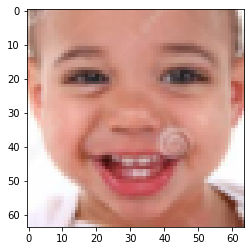

In [5]:
# visualization
import numpy as np
import matplotlib.pyplot as plt

#1 
dataiter = iter(train_loader)
images, labels = dataiter.next()

#2
img = images[8]
label = labels[8]
print(img.shape, label)
plt.imshow(img.permute(1, 2, 0))

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2d_bn_ReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(Conv2d_bn_ReLU, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        self.layers = nn.Sequential(*layers)
    def forward(self, x):
        return self.layers(x)

class GenderDiscriminator(nn.Module):
    def __init__(self):
        super(GenderDiscriminator, self).__init__()
        layers = [
            nn.Conv2d(3, 32, kernel_size=3, stride=2),
            Conv2d_bn_ReLU(32, 64, 3, 1),
            Conv2d_bn_ReLU(64, 128, 3, 2),
            # Conv2d_bn_ReLU(128, 256, 3, 1),
        ]
        self.layers = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
              nn.Linear(128, 2),
              nn.Softmax(),
        )
        for m in self.modules():
        	if isinstance(m, nn.Conv2d):
        		nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        		if m.bias is not None:
        			nn.init.constant_(m.bias, 0)
        		elif isinstance(m, nn.BatchNorm2d):
        			nn.init.constant_(m.weight, 1)
        			nn.init.constant_(m.bias, 0)
        		elif nn.init.constant_(m.bias, 0):
        			nn.init.normal_(m.weight, 0, 0.01)
        			nn.init.normal_(m.weight, 0, 0.01)
    def forward(self, x):
        output = x
        output = self.layers(x)

        output = F.avg_pool2d(output, [output.size(2), output.size(3)])
        output = output.reshape(output.shape[0], output.shape[1])

        output = self.classifier(output)
        return output

def train(model, train_loader):
    model.train()

    for epoch in range(epochs):
        avg_loss = 0.0
        print('Epoch: {}\tAcc: {:.4f}'.format(epoch+1, evaluate(model, train_loader)))
        for batch_num, (feats, labels) in enumerate(train_loader):
            feats, labels = feats.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(feats)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()

            if batch_num % 100 == 99:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/100))
                avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        torch.save(model, 'GD.pt')

def evaluate(model, dataloader):
    model.eval()
    Acc = 0
    Length = 0
    for batch_num, (feats, labels) in enumerate(train_loader):
        feats, labels = feats.to(device), labels
        outputs = model(feats).to('cpu')
        outputs = outputs.detach().numpy()
        prediction = outputs.argmax(axis=1)
        labels = labels.numpy()
        a = np.zeros(len(labels))
        a[prediction == labels] = 1
        acc, length = np.sum(a==1), len(a)
        Acc += acc
        Length += length
        
    return Acc/Length



In [0]:
lr = 0.001
epochs = 20

model = GenderDiscriminator()
model.to(device)
# model = torch.load('GD.pt').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

train(model, train_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
